### Importing Modules and Model File

In [46]:
begin
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()

end

include("modules/DataIO.jl")
include("modules/Classification.jl")
include("modules/Model.jl")
include("modules/EntropyUtil.jl")

using FLoops,
    FASTX,
    LinearAlgebra,
    Normalization,
    Statistics,
    Plots, 
    AbstractFFTs,
    Flux,
    Optimisers

using
    .DataIO,
    .Model,
    .EntropyUtil,
    .Classification

In [48]:
fasta::String = "/home/salipe/Desktop/datasets/test_voc/test/Alpha.fasta"
modelCachedFile::String = "$(pwd())/.project_cache/trained_model.dat"

sequences = Vector{String}()
for record in open(FASTAReader, fasta)
    seq::String = sequence(String, record)
    # id::String = identifier(record)
    # push!(sequences, (replace(id, r"\/|\|" => "_"), codeunits(seq)))
    push!(sequences, seq)
    break
end

model::Union{Nothing,Dict{String,Tuple{BitArray,Vector{Tuple{Int,Int,Vector{Float64}}},Vector{String}}}} = DataIO.load_cache(modelCachedFile)
@show model

Dict{String, Tuple{BitArray, Vector{Tuple{Int64, Int64, Vector{Float64}}}, Vector{String}}} with 5 entries:
  "Omicron" => ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]…
  "Beta"    => ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]…
  "Gamma"   => ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]…
  "Delta"   => ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]…
  "Alpha"   => ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]…

### Procesing model data

At this point the object is to extract a common value for each classes to apply to equation model

Each model have your own histogram generated by RRM function, extracting only de discriminative windows and regions,
by these histogram is possible to create Binary masks to retrieve regions.
Those regions are exclusive per class, how we know the SNPs from COVID are well distributed along the sequences, an intersection regions isn't useful.
The example is visible by the code below.

In [ ]:
finalHist::Union{Nothing,Vector{UInt16}} = nothing
finalMask::BitArray = trues(maximum(x -> length(x[2][1]), model))

plt = plot(title="Points")

for (key, (marked, _, kmers)) in model

    cache_path = "$(pwd())/.project_cache/$(key)_outmask.dat"
    cache::Union{Nothing,Tuple{String,Tuple{Vector{UInt16},BitArray},Vector{String}}} = DataIO.load_cache(cache_path)
    # plot!(marked)

    finalMask[1:length(marked)] = finalMask[1:length(marked)] .* marked
    if isnothing(finalHist)
        finalHist = cache[2][1]
    else
        current_hist = cache[2][1]
        max_len = max(length(finalHist), length(current_hist))

        # Create padded versions
        padded_final = [finalHist; ones(UInt16, max_len - length(finalHist))]
        padded_current = [current_hist; ones(UInt16, max_len - length(current_hist))]

        # Element-wise multiplication
        finalHist = padded_final .* padded_current
    end

end

start = 0
current = false


plot!(finalHist)
plot(plt)

#### Variants datas (change var name to explore all)

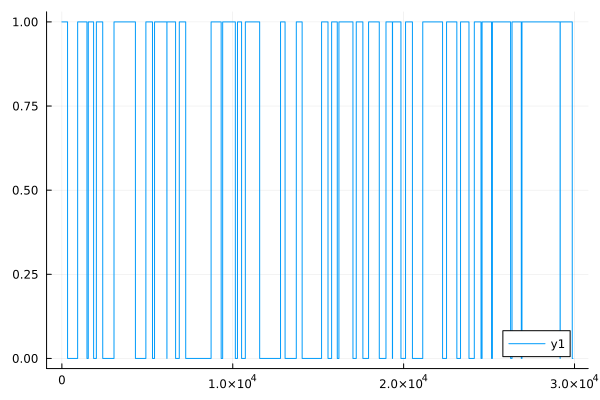

In [3]:
var = "Delta" # Alpha, Gamma, Beta, Omicron, Delta
cache_path = "$(pwd())/.project_cache/$(var)_outmask.dat"
cache::Union{Nothing,Tuple{String,Tuple{Vector{UInt16},BitArray},Vector{String}}} = DataIO.load_cache(cache_path)

# Window Histogram
wnwHist = cache[2][1]

mask = model[var][1]

plot(mask)

In [ ]:
teste = Vector{UnitRange{Int64}}()
for (i, bit) in enumerate(finalMask)
    if bit && !current
        start = i
        current = true
    elseif !bit && current
        current = false
        push!(teste, (start:i-1))
    end
end
if current
    push!(teste, (start:length(finalMask)))
end

@show teste

### Extracting a common value between classes

How the number of window regions and kmers are exclusive and variable between the classes, we need to crete a way to evaluate them as a unique way. THe approcah here wil bbe based on probabilities and entropy value.

So the steps applied will be:

1. **For each Class**
- Calculate the probability of appearence of kmers in each window region Pk = kmer_count/kmer_total;
- Calcuate the Shannon entropy for that class based on the propabilities applied in the class regions and kmers probalities.

2. **Mounting values to model an equation**

- By know we will have an data distribution like: ["class_1":H(x),"class_2":H(x),..."class_n":H(x)]

3. **Train model using hot-encoding and softmax**

#### Extract entropy values per class

In [ ]:
entropyValues = Vector{Tuple{String,Float64}}()

for (key, (marked, probs, kmers)) in model

    entropy = EntropyUtil.shannonEntropy(probs)

    push!(entropyValues, (key, entropy))
end

@show entropyValues


#### Training and predicting models 

In [ ]:
function softmax(z::AbstractMatrix)
    # Numerically stable implementation
    max_z = maximum(z, dims=ndims(z))
    exp_z = exp.(z .- max_z)
    sum_exp = sum(exp_z, dims=ndims(z))
    return exp_z ./ sum_exp
end

function onehotencode(labels::Union{Integer,AbstractArray{<:Integer}}, n_classes::Integer)
    # Handle scalar input
    if labels isa Integer
        @assert 1 <= labels <= n_classes "Label $labels out of range [1, $n_classes]"
        vec = zeros(Int, n_classes)
        vec[labels] = 1
        return vec
    end

    # Handle array input
    @assert all(1 .<= labels .<= n_classes) "Labels contain out-of-range values"
    matrix = zeros(Int, length(labels), n_classes)
    for (i, label) in enumerate(labels)
        matrix[i, label] = 1
    end
    return matrix
end

function cross_entropy(probabilities, y_onehot)
    -mean(sum(y_onehot .* log.(probabilities .+ eps(Float64)), dims=2))
end

#### Training functions

In [ ]:

mutable struct SoftmaxRegressor
    weights::Matrix{Float64}
    bias::Matrix{Float64}
    learning_rate::Float64
    classes::Int
end


function train!(model::SoftmaxRegressor, X::Matrix{Float64}, y::Vector{Int}, epochs=1000)
    m, n = size(X)
    y_onehot = onehotencode(y, model.classes)

    for epoch in 1:epochs
        # Forward pass
        logits = X * model.weights .+ model.bias
        probabilities = softmax(logits)

        # Compute loss
        loss = cross_entropy(probabilities, y_onehot)

        # Backward pass
        grad_logits = probabilities .- y_onehot
        grad_logits ./= m

        # Update parameters
        model.weights .-= model.learning_rate * X' * grad_logits
        model.bias .-= model.learning_rate * sum(grad_logits; dims=1)

        # Print progress
        if epoch % 100 == 0
            @info "Epoch $epoch - Loss: $loss"
        end
    end
end

In [ ]:
# Initialize model
model_struct = SoftmaxRegressor(
    randn(1, 5),  # weights (input_features × num_classes)
    zeros(1, 5),  # bias (1 × num_classes)
    0.01,
    5
)
# ("Omicron", 9.278283453361743)
# ("Beta", 7.030505818827168)
# ("Gamma", 0.0)
# ("Delta", 3.458885798328118)
# ("Alpha", 7.053015329074126)
# Sample data
X = [9.278283453361743; 7.030505818827168; 0.0; 3.458885798328118; 7.053015329074126]
X = reshape(X, :, 1)
# y = ["Omicron", "Beta", "Gamma", "Delta", "Alpha"]
y = [1, 2, 3, 4, 5]

# Train the model
train!(model_struct, X, y, 30)

In [ ]:
function predict(model::SoftmaxRegressor, X::Union{AbstractVector{Float64},Number})
    # Convert input to matrix format (n_samples × 1)
    X_matrix = X isa Number ? reshape([Float64(X)], 1, 1) : reshape(X, :, 1)

    # Compute logits (n_samples × n_classes)
    logits = X_matrix * model.weights .+ model.bias

    # Compute probabilities using row-wise softmax
    probabilities = softmax(logits)

    # Get predicted class indices (1-based)
    max_indices = argmax(probabilities; dims=2)
    classes = [idx[2] for idx in max_indices]

    return classes
end

X_test = [9.5, 2.0]
predictions = predict(model_struct, X_test)

### Sigmoid multi block approach

Optimisers: https://fluxml.ai/Optimisers.jl/stable/api/

In [3]:
mutable struct SigmoidBlockRegressor
    class::String
    models::Vector{Tuple{Int,Int,Vector{Float64},Any}}
end

mutable struct ModelClassChain
    blockmodelchain::Array{SigmoidBlockRegressor}
end

In [119]:

function createModelBlock(
    blockClassName::String,
    regionsFourierCoefs::Vector{Tuple{Int,Int,Vector{Float64}}},
    trueSequences::Vector{Vector{Float64}},
    falseSequences::Vector{Vector{Float64}},
    epochs=10)::SigmoidBlockRegressor

    block_model = SigmoidBlockRegressor(blockClassName, Vector{Tuple{Int,Int,Flux.Dense}}())
    falsesamples = length(falseSequences)

    # para cada região criar uma sigmoid para comparação entre sinais
    for (initIdx, endIdx, cross) in regionsFourierCoefs
        X = Vector{Vector{Float64}}()
        labels = Vector{Float64}()

        freIndexes::Vector{Int} = filter(ii -> cross[ii] >= 0.1, eachindex(cross))

        minFreq::Int = maximum(freIndexes)
        maxFreq::Int = maximum(freIndexes)

        #extract all the fft from each region
        for seq in falseSequences
            if lastindex(seq) >= endIdx
                dft = abs.(rfft(seq[initIdx:endIdx])[2:end])
                # espc::Vector{Float64} = dft .* cross

                # N = MinMax(dft)
                # norm = N(dft)
                push!(X, dft[minFreq:maxFreq])
                push!(labels, zero(Float64))
            end
        end
        for seq in trueSequences
            if lastindex(seq) >= endIdx
                dft = abs.(rfft(seq[initIdx:endIdx])[2:end])
                # espc::Vector{Float64} = dft .* cross

                # N = MinMax(dft)
                # norm = N(dft)
                push!(X, dft[minFreq:maxFreq])
                push!(labels, one(Float64))
            end
        end


        push!(block_model.models, (initIdx, endIdx, cross, trainLinearReg(X, labels, epochs)))
    end
    return block_model
end

function trainLinearReg(X::Vector{Vector{Float64}}, y::Vector{Float64}, epochs)
    X_matrix = hcat(X...)  # Convert list of vectors into a matrix
    n_features, n_samples = size(X_matrix)  # Get the correct dimensions

    # Ensure y is a row vector with correct dimensions (1 x n_samples)
    y = reshape(y, 1, n_samples)

    # μ = mean(X_matrix, dims=2)
    # σ = std(X_matrix, dims=2)
    # X_normalized = (X_matrix .- μ) ./ (σ .+ 1e-6)

    hidden_units = div(n_features, 2)

    model = Chain(
        Dense(n_features => 64, relu),
        Dropout(0.5),
        Dense(64 => 32, relu),
        Dense(32 => 1, sigmoid)
       
    )

    # Função de perda (cross-entropy)
    # loss( x, y) = Flux.Losses.mse(model(x), y)
    loss(x, y) = Flux.binarycrossentropy(model(x), y)

    opt = Optimisers.Adam()
    state = Optimisers.setup(opt, model)

    # data_loader = Flux.DataLoader((X_matrix, y), batchsize=32, shuffle=true)
    for epoch in 1:epochs
        # for (x_batch, y_batch) in data_loader
        grads = Flux.gradient(model) do m
            loss(X_matrix, y)
        end

        # Atualiza os pesos do modelo
        Optimisers.update!(state, model, grads)
        # @info "Epoch $epoch" loss = loss(X_matrix, y)

    end
    return model
end


function trainSigmoidReg(X::Vector{Vector{Float64}}, y::Vector{Int8}, epochs=1000)


    # Converter X para matriz (cada coluna é uma amostra)
    X_matrix = hcat(X...)  # Transforma lista de vetores em matriz
    n_features = size(X_matrix, 1)

    y = y'

    # Definição do modelo
    model = Chain(Dense(n_features, 1, σ), sigmoid)

    # Função de perda (cross-entropy)
    loss(model, x, y) = Flux.Losses.binarycrossentropy(model(x), y)

    # Configuração do otimizador no novo estilo do Flux
    opt = Optimisers.Adam(0.005)
    state = Optimisers.setup(opt, model)

    # Loop de treinamento
    for epoch in 1:epochs
        grads = Flux.gradient(model) do m
            loss(m, X_matrix, y)
        end

        # Atualiza os pesos do modelo
        Optimisers.update!(state, model, grads)

        if epoch % 10 == 0
            println("Epoch $epoch - Loss: ", loss(model, X_matrix, y))
        end
    end

    return model
end


trainSigmoidReg (generic function with 2 methods)

In [120]:
classes = ["Alpha", "Delta", "Beta", "Gamma", "Omicron"]
mdelstruct = ModelClassChain(Array{SigmoidBlockRegressor}(undef, length(classes)))

@inbounds for i in eachindex(classes)
    class::String = classes[i]
    # para cada classe criar seu bloco de modelos sigmois para cada região
    falseSequences = Vector{Vector{Float64}}()
    trueSequences = Vector{Vector{Float64}}()
    for key in classes
        cache_path = "$(pwd())/.project_cache/$(key)_outmask.dat"
        vardata::Union{Nothing,Tuple{String,Tuple{Vector{UInt16},BitArray},Vector{String}}} = DataIO.load_cache(cache_path)
        sqs::Vector{String} = vardata[3]
        if key != class
            @inbounds for i in eachindex(sqs)
                push!(falseSequences, DataIO.sequence2NumericalSerie(sqs[i]))
            end
        else
            @inbounds for i in eachindex(sqs)
                push!(trueSequences, DataIO.sequence2NumericalSerie(sqs[i]))
            end
        end
    end
    mdelstruct.blockmodelchain[i] = createModelBlock(class, model[class][2], trueSequences, falseSequences, 100)
end

mdelstruct

ModelClassChain(SigmoidBlockRegressor[SigmoidBlockRegressor("Alpha", Tuple{Int64, Int64, Vector{Float64}, Any}[(648, 1031, [1.0034405464544903e-284, 3.276656529556527e-107, 1.8777110105891545e-144, 7.6058067690181945e-109, 1.3317960674468566e-125, 2.1066383035587063e-208, 2.3863454317536324e-183, 5.27739457398339e-71, 3.913408473839599e-136, 4.932367925400203e-189  …  1.9953044763684534e-143, 2.8568340802125728e-49, 2.414794360270879e-34, 3.4275567431416337e-115, 7.191587766711196e-104, 4.803460430644944e-141, 6.87192843542237e-78, 8.538176374877905e-205, 3.6957183122501996e-66, 6.200082239135967e-193], Chain(Dense(1 => 64, relu), Dropout(0.5), Dense(64 => 32, relu), Dense(32 => 1, σ))), (1174, 1492, [3.0884481398137894e-119, 4.6629793830689036e-136, 7.754628266979578e-176, 2.4794187413600118e-73, 5.744388320405756e-204, 2.017750854612346e-164, 2.022383444002724e-188, 0.0, 3.615608482521676e-143, 9.364670009406544e-81  …  8.565473950184236e-56, 1.1806368157787833e-179, 1.50906058876125

In [121]:
inputSequence = sequences[1]

testSeq = DataIO.sequence2NumericalSerie(inputSequence)

open("reportFilename.txt", "w") do file
    for block in mdelstruct.blockmodelchain
        write(file, "\n\n########### $(uppercase(block.class)) ############")
        for (initi, endi, cross, c_model) in block.models


            freIndexes::Vector{Int} = filter(ii -> cross[ii] >= 0.2, eachindex(cross))

            minFreq::Int = maximum(freIndexes)
            maxFreq::Int = maximum(freIndexes)

            if lastindex(testSeq) >= endi
                dft = abs.(rfft(testSeq[initi:endi])[2:end])
                # espc::Vector{Float64} = dft .* cross

                # N = MinMax(dft)
                # norm = N(dft)
                norm = dft[minFreq:maxFreq]
                raw_output = c_model(reshape(norm, :, 1))[1]

                write(file, "\nWindow Position( $initi - $endi ): \nClassification: $(raw_output >= 0.5f0)")
            end

        end

    end
end

# Classification.classifyInput(codeunits(inputSequence), model, nothing)


---


Thrash content trying to extract some values from instecsioned windows

---

In [ ]:
chart = Vector{Tuple{String,Vector{Int16}}}()
(id, inputSequence) = sequences[1]

for (key, (marked, _, kmers)) in model
    probs = Vector{Integer}()
    inputlen = minimum(length, [inputSequence, marked])
    limitedMark::BitArray = marked[1:inputlen]
    start = 0
    current = false

    for (i, bit) in enumerate(limitedMark)
        if bit && !current
            start = i
            current = true
        elseif !bit && current
            current = false
            count = @views Classification.countPatterns(inputSequence[start:i-1], kmers)

            push!(probs, convert(Int16, count))
        end
    end
    if current
        if (length([start:inputlen]) < length(kmers[1]))
            start = start - length(kmers[1])
        end

        count = @views Classification.countPatterns(inputSequence[start:inputlen], kmers)
        push!(probs, convert(Int16, count))


    end

    push!(chart, (key, probs))
end


@show chart


In [ ]:

max_len = maximum(x -> length(x[2]), chart)
x = [reshape([var[2]; zeros(Int16, max_len - length(var[2]))], (1, max_len)) for var in chart]

N, L, C = 1, max_len, 5  # Batch size 1, sequence length 35, 5 classes
logits = Array{Int16}(undef, 1, max_len, 5)

for i in 1:length(x)
    logits[:, :, i] = x[i]
end


y_indices = rand(1:C, N, L)  # Class indices for each position

# Convert to one-hot (optional)
y_true = Flux.onehotbatch(vec(y_indices), 1:C)  # Shape (C, N*L)
y_true = reshape(y_true, C, N, L)  # Reshape to (N, L, C)
y_true = permutedims(y_true, (2, 3, 1))  # Final shape (N, L, C)

# Compute loss
log_probs = Flux.logsoftmax(logits; dims=3)
loss = -mean(y_true .* log_probs)




In [ ]:
@show y_true